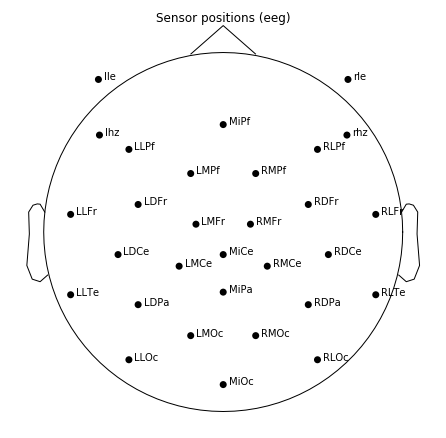

In [1]:
#%matplotlib qt5
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import mne
from mne.datasets import somato
from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval
from collections import OrderedDict
import spudtr.filters as filters

#import spudtr.mneutils as mneutils
from spudtr import DATA_DIR, mneutils

_f, _key = DATA_DIR / "gh_sub000p3.epochs.h5", "p3"
epochs_df = pd.read_hdf(_f, _key)


eeg_streams = ['lle', 'lhz', 'MiPf', 'LLPf', 'RLPf',
       'LMPf', 'RMPf', 'LDFr', 'RDFr', 'LLFr', 'RLFr', 'LMFr', 'RMFr', 'LMCe',
       'RMCe', 'MiCe', 'MiPa', 'LDCe', 'RDCe', 'LDPa', 'RDPa', 'LMOc', 'RMOc',
       'LLTe', 'RLTe', 'LLOc', 'RLOc', 'MiOc', 'rle', 'rhz']

# plot montage
sfreq = 500

montage =  mneutils.streams2mne_digmont(eeg_streams)
montage.plot(kind='topomap', show_names=True);


In [2]:
# let's explore some frequency bands
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [3]:

frequency_map = list()
sfreq = 500.0
eeg_streams = ['MiPf','MiCe', 'MiPa', 'MiOc']

# build a minimal spudtr epochs_df with one row per event
epoch_id = "epoch_id"
time = "time_ms"
#time = "match_time"
time_stamp = 0
categories = "stim"
#categories = "click"
mne_event_id, mne_events = mneutils._categories2eventid(
    epochs_df, categories, epoch_id, time, time_stamp
)
data=epochs_df[eeg_streams].to_numpy().T
data=data.astype('float64')

epochs_df_mne = epochs_df.copy()

for band, fmin, fmax in iter_freqs:

    data_filtered = mne.filter.filter_data(data, sfreq, fmin, fmax)
    data_filtered1=data_filtered.T
    epochs_df_mne[eeg_streams]=data_filtered1
    epochs = mneutils.spudtr2mne_epochs(epochs_df_mne, eeg_streams, time, epoch_id, sfreq, mne_events, mne_event_id)

    # remove evoked response
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    del epochs

Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 825 samples (1.650 sec)

792 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition

[0.  1.  0.5 1. ]
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[0.         0.66666667 0.66666667 1.        ]
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[0.         0.33333333 0.83333333 1.        ]
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[0. 0. 1. 1.]
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

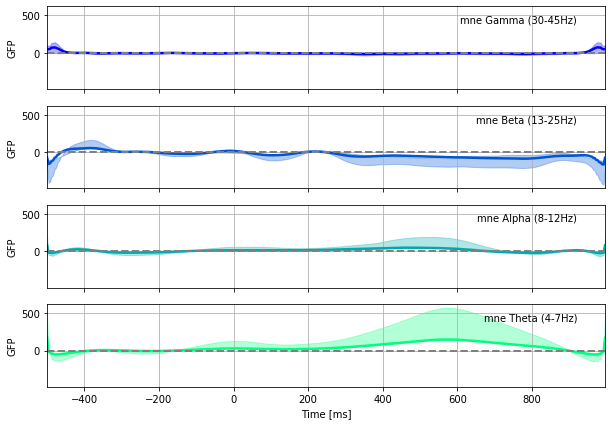

In [4]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    #times = average.times * 1e3
    times = np.unique(epochs_df[time].to_list())
    print(color)
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, times, baseline=(None, 0))
    ci_up = rescale(ci_up, times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('mne %s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(min(times), max(times))

axes.ravel()[-1].set_xlabel('Time [ms]')

In [5]:

frequency_map = list()
sfreq = 500.0
eeg_streams = ['MiPf','MiCe', 'MiPa', 'MiOc']

# build a minimal spudtr epochs_df with one row per event
epoch_id = "epoch_id"
time = "time_ms"
#time = "match_time"
time_stamp = 0
categories = "stim"
#categories = "click"
mne_event_id, mne_events = mneutils._categories2eventid(
    epochs_df, categories, epoch_id, time, time_stamp
)

ftype = "bandpass"

for band, fmin, fmax in iter_freqs:
    
    cutoff_hz = [fmin, fmax]
    epochs_df_spudtr = filters.fir_filter_dt(
               epochs_df, eeg_streams, cutoff_hz, sfreq, ftype, window='hamming')
    epochs = mneutils.spudtr2mne_epochs(epochs_df_spudtr, eeg_streams, time, epoch_id, sfreq, mne_events, mne_event_id)

    # remove evoked response
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    del epochs

792 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
792 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
792 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
792 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]


[0.  1.  0.5 1. ]
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[0.         0.66666667 0.66666667 1.        ]
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[0.         0.33333333 0.83333333 1.        ]
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[0. 0. 1. 1.]
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

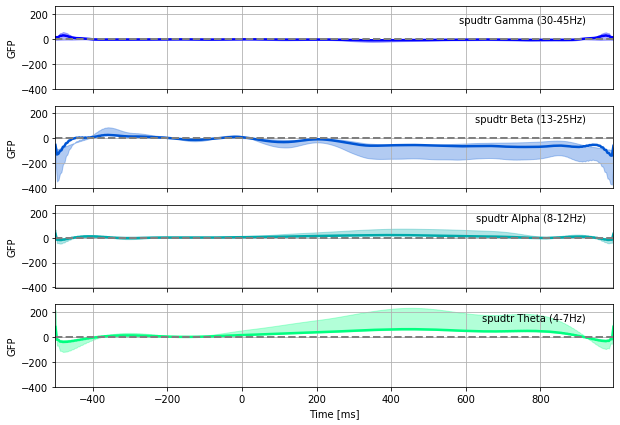

In [6]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    #times = average.times * 1e3
    times = np.unique(epochs_df[time].to_list())
    print(color)
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, times, baseline=(None, 0))
    ci_up = rescale(ci_up, times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('spudtr %s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(min(times), max(times))

axes.ravel()[-1].set_xlabel('Time [ms]')